# Imports

In [1]:
from tqdm import tqdm
import numpy as np
import json
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load JSON Files as Datasets

In [2]:
class JSONDataset(Dataset):
    def __init__(self, json_file, transform=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

def custom_transform(sample):
    input_data = torch.tensor([
        sample['PTS'], 
        sample['REB'], 
        sample['AST'], 
        sample['STL'], 
        sample['BLK']
    ], dtype=torch.float32)
    
    target = input_data.clone()
    
    return input_data, target

In [3]:
NUM_EPOCHS = 40
BATCH_SIZE = 2
lr = 0.001

In [4]:
def get_json_file_paths(directory):
    json_file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                json_file_paths.append(os.path.relpath(os.path.join(root, file), directory))
    return json_file_paths

json_file_paths = get_json_file_paths(".")
print("Relative JSON file paths:")
print(json_file_paths)

Relative JSON file paths:
['Luka_Doncic_2018-19_regular_season_games.json', 'Luka_Doncic_2019-20_regular_season_games.json', 'Luka_Doncic_2020-21_regular_season_games.json', 'Luka_Doncic_2021-22_regular_season_games.json', 'Luka_Doncic_2022-23_regular_season_games.json', 'Luka_Doncic_2023-24_regular_season_games.json']


In [5]:
train_datasets = [JSONDataset(json_file, transform=custom_transform) for json_file in json_file_paths[0:-2]]
train_loaders = [DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in train_datasets]

val_dataset = JSONDataset(json_file_paths[-2], transform=custom_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = JSONDataset(json_file_paths[-1], transform=custom_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Setup NN Model, Loss function & Validation Function

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

In [7]:
model = LSTMModel(5,128,5).to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0)

In [8]:
def test(loader, model, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training Loop

In [9]:
for epoch in range(NUM_EPOCHS):
    model.train()
    print(f'==> Epoch {epoch+1}')
    
    for loader in train_loaders:
        for inputs, targets in tqdm(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    val_loss = test(val_loader, model, criterion)
    print(f'Validation Loss: {val_loss:.3f}')

==> Epoch 1


100%|██████████| 42/42 [00:00<00:00, 518.52it/s]


Validation Loss: 75.114
==> Epoch 2


100%|██████████| 42/42 [00:00<00:00, 511.75it/s]


Validation Loss: 25.563
==> Epoch 3


100%|██████████| 42/42 [00:00<00:00, 538.43it/s]


Validation Loss: 13.311
==> Epoch 4


100%|██████████| 42/42 [00:00<00:00, 531.65it/s]


Validation Loss: 8.472
==> Epoch 5


100%|██████████| 42/42 [00:00<00:00, 506.03it/s]


Validation Loss: 6.011
==> Epoch 6


100%|██████████| 42/42 [00:00<00:00, 538.02it/s]


Validation Loss: 4.196
==> Epoch 7


100%|██████████| 42/42 [00:00<00:00, 512.20it/s]


Validation Loss: 3.243
==> Epoch 8


100%|██████████| 42/42 [00:00<00:00, 531.64it/s]


Validation Loss: 2.611
==> Epoch 9


100%|██████████| 42/42 [00:00<00:00, 518.53it/s]


Validation Loss: 2.197
==> Epoch 10


100%|██████████| 42/42 [00:00<00:00, 538.46it/s]


Validation Loss: 1.722
==> Epoch 11


100%|██████████| 42/42 [00:00<00:00, 512.18it/s]


Validation Loss: 1.477
==> Epoch 12


100%|██████████| 42/42 [00:00<00:00, 442.01it/s]


Validation Loss: 1.264
==> Epoch 13


100%|██████████| 42/42 [00:00<00:00, 407.14it/s]


Validation Loss: 1.136
==> Epoch 14


100%|██████████| 42/42 [00:00<00:00, 442.08it/s]


Validation Loss: 1.018
==> Epoch 15


100%|██████████| 42/42 [00:00<00:00, 308.82it/s]


Validation Loss: 1.137
==> Epoch 16


100%|██████████| 42/42 [00:00<00:00, 293.62it/s]


Validation Loss: 0.827
==> Epoch 17


100%|██████████| 42/42 [00:00<00:00, 285.71it/s]


Validation Loss: 0.810
==> Epoch 18


100%|██████████| 42/42 [00:00<00:00, 291.52it/s]


Validation Loss: 0.803
==> Epoch 19


100%|██████████| 42/42 [00:00<00:00, 285.71it/s]


Validation Loss: 0.679
==> Epoch 20


100%|██████████| 42/42 [00:00<00:00, 311.11it/s]


Validation Loss: 0.636
==> Epoch 21


100%|██████████| 42/42 [00:00<00:00, 200.00it/s]


Validation Loss: 0.823
==> Epoch 22


100%|██████████| 42/42 [00:00<00:00, 325.54it/s]


Validation Loss: 0.559
==> Epoch 23


100%|██████████| 42/42 [00:00<00:00, 306.56it/s]


Validation Loss: 0.562
==> Epoch 24


100%|██████████| 42/42 [00:00<00:00, 274.50it/s]


Validation Loss: 0.518
==> Epoch 25


100%|██████████| 42/42 [00:00<00:00, 304.35it/s]


Validation Loss: 0.633
==> Epoch 26


100%|██████████| 42/42 [00:00<00:00, 295.78it/s]


Validation Loss: 0.794
==> Epoch 27


100%|██████████| 42/42 [00:00<00:00, 291.67it/s]


Validation Loss: 0.431
==> Epoch 28


100%|██████████| 42/42 [00:00<00:00, 333.34it/s]


Validation Loss: 0.403
==> Epoch 29


100%|██████████| 42/42 [00:00<00:00, 285.72it/s]


Validation Loss: 0.400
==> Epoch 30


100%|██████████| 42/42 [00:00<00:00, 217.62it/s]


Validation Loss: 0.357
==> Epoch 31


100%|██████████| 42/42 [00:00<00:00, 265.83it/s]


Validation Loss: 0.430
==> Epoch 32


100%|██████████| 42/42 [00:00<00:00, 262.37it/s]


Validation Loss: 0.356
==> Epoch 33


100%|██████████| 42/42 [00:00<00:00, 265.82it/s]


Validation Loss: 0.356
==> Epoch 34


100%|██████████| 42/42 [00:00<00:00, 306.19it/s]


Validation Loss: 0.333
==> Epoch 35


100%|██████████| 42/42 [00:00<00:00, 325.57it/s]


Validation Loss: 0.397
==> Epoch 36


100%|██████████| 42/42 [00:00<00:00, 297.86it/s]


Validation Loss: 0.296
==> Epoch 37


100%|██████████| 42/42 [00:00<00:00, 323.06it/s]


Validation Loss: 0.283
==> Epoch 38


100%|██████████| 42/42 [00:00<00:00, 308.82it/s]


Validation Loss: 0.274
==> Epoch 39


100%|██████████| 42/42 [00:00<00:00, 335.99it/s]


Validation Loss: 0.267
==> Epoch 40


100%|██████████| 42/42 [00:00<00:00, 318.19it/s]

Validation Loss: 0.274


# Testing Metrics

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1) 
        outputs = model(inputs)
        
        targets_np = targets.cpu().numpy()
        outputs_np = outputs.cpu().numpy()
        
        true_labels.extend(targets_np)
        predictions.extend(outputs_np)

predictions = np.array(predictions)
true_labels = np.array(true_labels)

mse = mean_squared_error(true_labels, predictions)
mae = mean_absolute_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.4863081
Mean Absolute Error (MAE): 0.179561
R-squared (R2): 0.9857286214828491


# Plot Predicted vs Actual Season Statistics

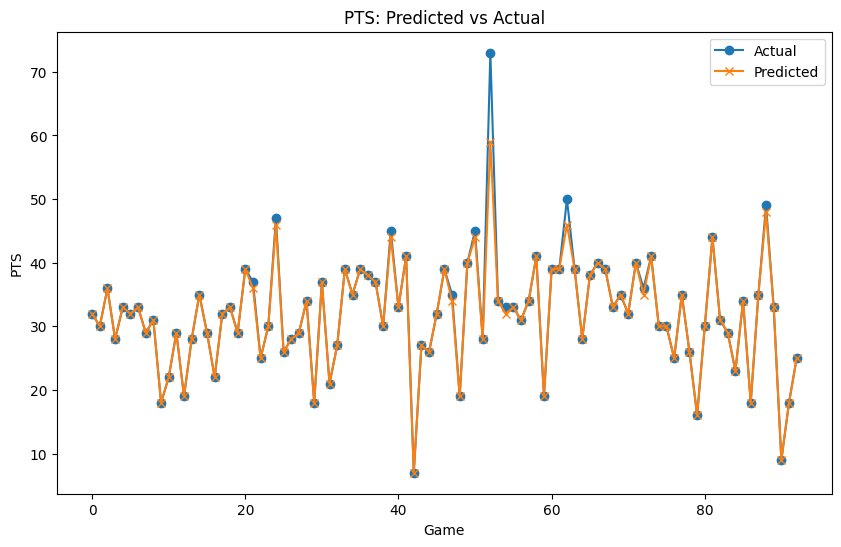

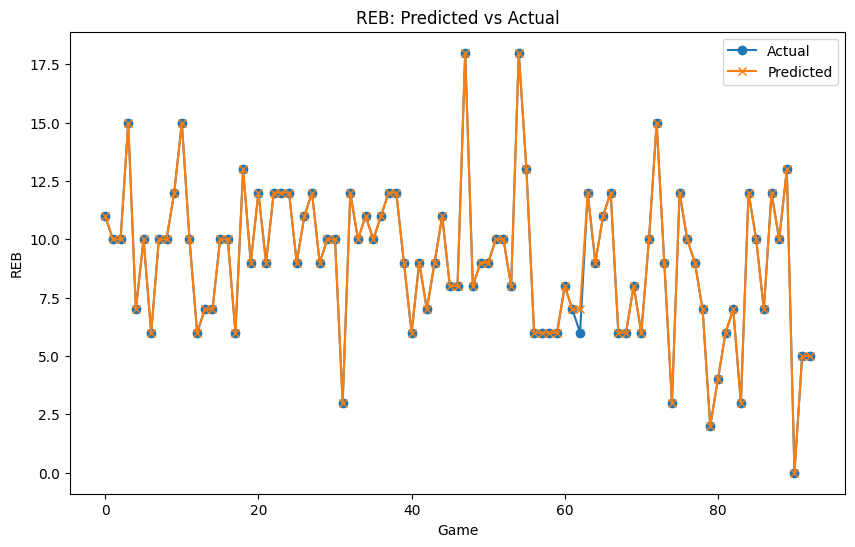

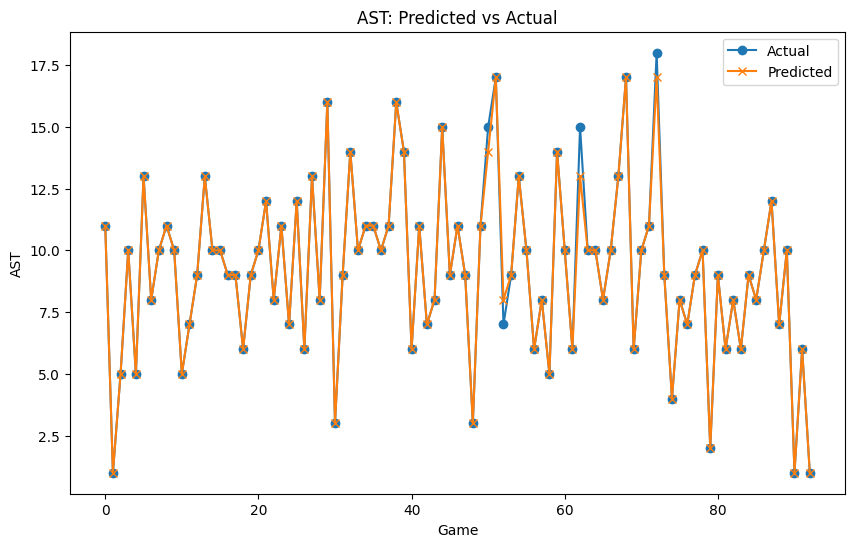

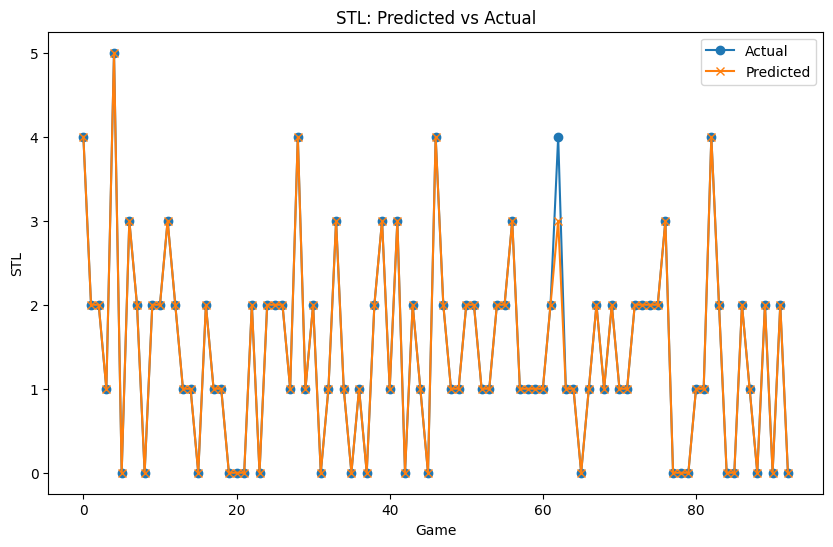

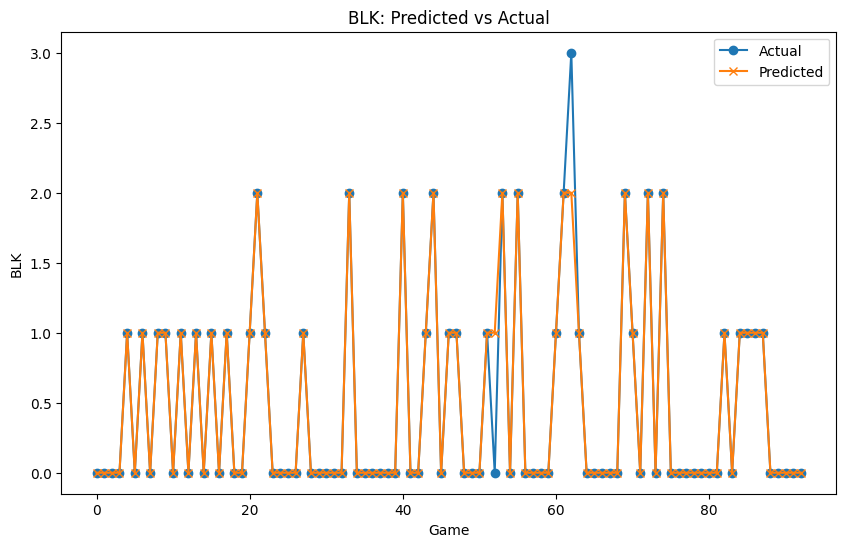

In [11]:
import matplotlib.pyplot as plt

for i, metric in enumerate(['PTS', 'REB', 'AST', 'STL', 'BLK']):
    plt.figure(figsize=(10, 6))
    plt.plot(true_labels[:, i], label='Actual', marker='o')
    plt.plot(np.maximum(np.round(predictions[:, i]), 0), label='Predicted', marker='x')
    plt.title(f'{metric}: Predicted vs Actual')
    plt.xlabel('Game')
    plt.ylabel(metric)
    plt.legend()
    plt.show()



# Find Game Specific Stats

In [12]:
def find_game_index_by_date(target_game_date):
    with open(json_file_paths[5], 'r') as f:
        data = json.load(f)
    
    for index, game in enumerate(data):
        if game.get('GAME_DATE') == target_game_date:
            return index
    
    # Return None if game date is not found
    return None

Predicted Values: [32. 11. 11.  4.  0.]
Actual Values: [32. 11. 11.  4.  0.]


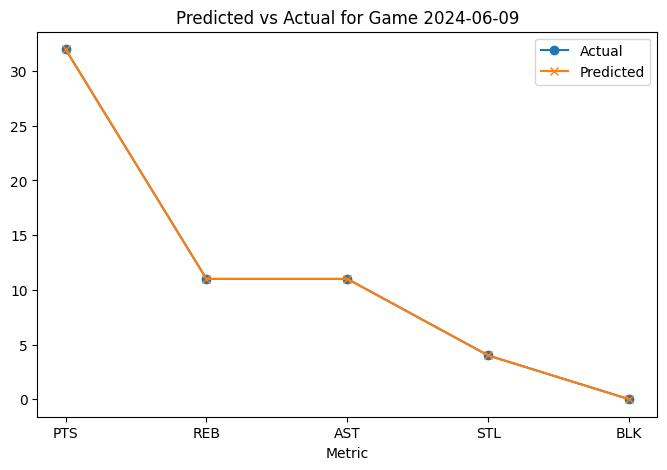

In [13]:
def plot_predictions_vs_actuals_for_game(model, loader, device, game_date):
    model.eval()
    game_index = find_game_index_by_date(game_date)
    
    # Get inputs and targets for the specified game
    inputs, targets = next(iter(loader))
    inputs, targets = inputs[game_index].unsqueeze(0).unsqueeze(0).to(device), targets[game_index].unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        predictions = outputs.cpu().numpy()
        true_labels = targets.cpu().numpy()
    
    rounded_predictions = np.maximum(np.round(predictions.flatten()), 0)

    plt.figure(figsize=(8, 5))
    plt.plot(true_labels.flatten(), label='Actual', marker='o')
    plt.plot(rounded_predictions, label='Predicted', marker='x')

    print("Predicted Values:", rounded_predictions)
    print("Actual Values:", true_labels.flatten())

    metric_names = ['PTS', 'REB', 'AST', 'STL', 'BLK']  # Example metric names
    plt.xticks(np.arange(len(metric_names)), metric_names)  # Set the ticks and labels

    plt.title(f'Predicted vs Actual for Game {game_date}')
    plt.xlabel('Metric')
    plt.legend()
    plt.show()

plot_predictions_vs_actuals_for_game(model, test_loader, device, "2024-06-09")
